# AMP-PD Clinical Data Analysis
Entropy Rate (ER) of single and multi dimensions of UPDRS dimensions. The ER shows average amount of entropy increase following after each new sample data added.

- calculate ER of UPDRS-1 score for a sample patient
- calculate ER of UPDRS-1,2,3,4 for all patients, separately in 4 dimensions
- calculate ER of UPDRS-1,2,3,4 combined, for all patients

In [1]:
import os
import numpy as np
import pandas as pd
from preprocessing.paths import pointwise_features_path, jarLocation
from infotheory import *
import jpype


# check java location
assert os.path.isfile(jarLocation)
# start JVM
if (not jpype.isJVMStarted()):
    # Start the JVM (add the "-Xmx" option with say 1024M if you get crashes due to not enough memory space)
    jpype.startJVM(jpype.getDefaultJVMPath(), "-ea", "-Djava.class.path=" + jarLocation, convertStrings=True)

## Imports and data loading

The Entropy Rate analysis uses pointwise propagation speed of UPDRS development in 4 UPDRS dimensions.

Load pointwise processed data, with propagation speed calculated using following equation. $u$ denotes UPDRS score in any dimensions $\{1,2,3,4\}$, and $m$ denotes month number.

$${propagation\ speed} = \frac{u_{curr} - u_{prev}}{m_{curr} - m_{prev}}$$

In [ ]:
# whole pointwise dataset
df_pointwise = pd.read_csv(pointwise_features_path)
# grouped by patient ids for info theory calculations
df_pointwise_group = df_pointwise.groupby('patient_id')
# sample patient profile 
df_pointwise_55 = df_pointwise[df_pointwise['patient_id']==55]
df_pointwise_55 = df_pointwise_55[['month']+[f'updrs_{i}_dt' for i in (1,2,3,4)]]
df_pointwise_55 = df_pointwise_55.bfill()
# show samples of pointwise dataset
df_pointwise.head(3)


## Single-dimensional entropy rate

Entropy rate of single dimensional UPDRS propagation rate (score per month), for a single patient. Uses calculations as follows:

$$
H(X_n|x_{n-1}^{(k)}) = H(X_{n-k-1}, \dots, X_{n-1}, X_{n}) - H(X_{n-k-1}, \dots, X_{n-1})
$$

JIDT currently do not provide code generator for multivariate Joint Entropy, use Gaussian Estimator instead.

Function below uses Gaussian Estimator to make estimates of Joint Entropy for n arrays $H(x_{1}, x_{2}, \dots , x_{n})$ , with the assumption that $x \in \mathbb{R}^{D}$ follows normal distribution in $D$ dimensions, i.e. $x \sim N_{D}(\mu, \Sigma)$, where:

$\Sigma_{i,j} = {Cov}[x_i, x_j]$ , and

$H(x) = \frac{D}{2}(1+\log{(2\pi)}) + \frac{1}{2}\log{|\Sigma|}$

In [3]:
# functions moved to infotheory.py
from infotheory import *

In [35]:
# poc: np.ndarray covariance between rows

# Example 2-dimensional array
# data = np.array([[1, 1.5, 3], [6, 3, 4], [7, 3, 8]])
array_length = 21
# base = np.sin(np.linspace(0, 2 * np.pi, array_length))
base = np.linspace(0, 2 * np.pi, array_length)
# shift_array(test_array, 3)
base_er = entropy_rate(base)
print('base:', base_er)
displacement_er = entropy_rate(displacement)
print('displacement:', displacement_er)
for factor in (15, 3, 1, 0.5, 0.1, 0.01, 0.001, 0.0001, 0.00001):
    fluctuation = np.random.normal(0, factor, size=array_length)
    displacement = np.cumsum(fluctuation)
    test_array = base + displacement
    er = entropy_rate(test_array)
    print(f'base + {factor} variance:', er)


base: -3.194356576846456
displacement: 107.20402877299438
base + 15 variance: -34.58780105536158
base + 3 variance: -11.130524120182606
base + 1 variance: -4.162999414338195
base + 0.5 variance: 12.146791353546895
base + 0.1 variance: 27.418708899923075
base + 0.01 variance: 57.70825085766407
base + 0.001 variance: 81.42871372156247
base + 0.0001 variance: 110.77604003016569
base + 1e-05 variance: -3.1943752272543193


intercept -1.5978597987414354


Text(0, 0.5, 'ER (nats)')

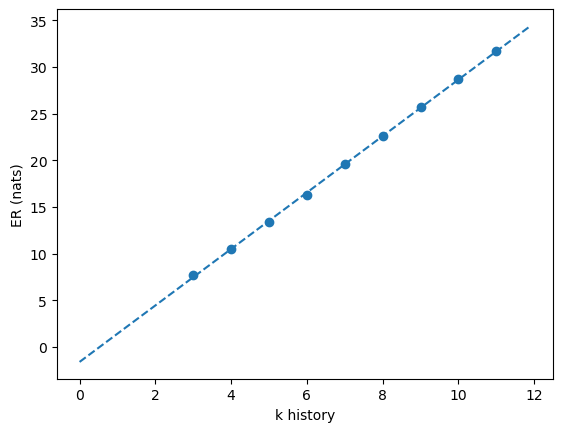

In [4]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

updrs_spd = df_pointwise_55[f"updrs_1_dt"]
updrs_spd = updrs_spd[updrs_spd.notna()]
k_values = np.arange(3, 12, 1)
er_values = []
for k in k_values:
    er = entropy_rate(updrs_spd, k=int(k))
    er_values.append(er)
plt.scatter(k_values, er_values)
lr = LinearRegression()
lr.fit(k_values.reshape(-1, 1), np.array(er_values))
x = np.arange(0, 12, 0.1).reshape(-1, 1)
y = lr.predict(x)
print("intercept", lr.intercept_)
plt.plot(x,y, '--')
plt.xlabel('k history')
plt.ylabel('ER (nats)')

In [6]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

for i in (1,2,3,4):
    sample_patients = df_pointwise['patient_id'].sample(20)
    df_patients = [
        df_pointwise[df_pointwise['patient_id'] == patient_id]
        for patient_id in sample_patients]
    intercepts = []
    for df_patient in df_patients:
        updrs_spd = df_pointwise_55[f"updrs_{i}_dt"]
        updrs_spd = updrs_spd[updrs_spd.notna()]
        k_values = np.arange(3, 9, 1)
        er_values = []
        for k in k_values:
            er = entropy_rate(updrs_spd, k=int(k))
            er_values.append(er)
        lr = LinearRegression()
        lr.fit(k_values.reshape(-1, 1), np.array(er_values))
        x = np.arange(0, 12, 0.1).reshape(-1, 1)
        y = lr.predict(x)
        intercepts.append(lr.intercept_)
    print(f'mean intercepts updrs-{i}:', np.mean(intercepts))

mean intercepts updrs-1: -1.4373657476936486
mean intercepts updrs-2: -1.6326129323179401
mean intercepts updrs-3: -4.210736766092582
mean intercepts updrs-4: 0.0


In [74]:
k_values.reshape(-1, 1)

array([[ 3],
       [ 4],
       [ 5],
       [ 6],
       [ 7],
       [ 8],
       [ 9],
       [10],
       [11]])

In [64]:
for i in (1,2,3,4):
    updrs_spd = df_pointwise_55[f"updrs_{i}_dt"]
    updrs_spd = updrs_spd[updrs_spd.notna()]
    er = entropy_rate(updrs_spd, k=5)
    print(f'updrs {i}:', er)

updrs 1: 13.34497436753021
updrs 2: 16.928050191659622
updrs 3: 4.544776264543545
updrs 4: 0.0


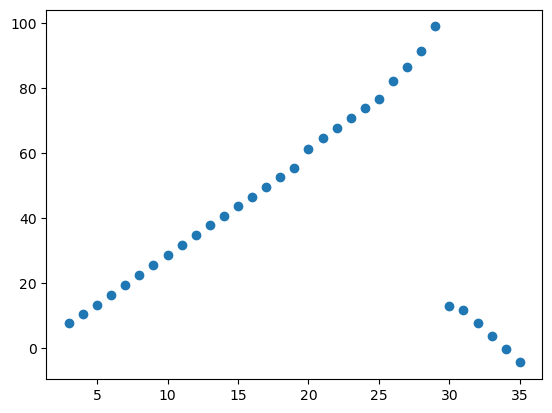

In [ ]:
updrs_spd = df_pointwise_55[f"updrs_1_dt"]
updrs_spd = updrs_spd[updrs_spd.notna()]
k_values = np.arange(3, 36, 1)
er_values = []
for k in k_values:
    er = entropy_rate(updrs_spd, k=int(k))
    er_values.append(er)
plt.scatter(k_values, er_values)
plt.xlabel()

In [82]:
max(er_values)

98.9718090745323